In [42]:
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Off FutureWarnings
import warnings
warnings.filterwarnings('ignore')

#Resampling
from imblearn.over_sampling import SMOTENC
from sklearn.utils import class_weight

#Dimension Reduction
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Models Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# Model evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

# Save model
import pickle

In [43]:
## Upload df
df = pd.read_csv("failures_data.csv")
pd.options.mode.chained_assignment = None
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


In [44]:
# Verify if the data has duplicate values
data_duplicates = df.duplicated().sum()
print("Total duplicated values: ", data_duplicates)

Total duplicated values:  0


In [45]:
data_null = df.isnull().sum().sum()
print("Total missing values: ", data_null)

Total missing values:  0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [47]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [48]:
df.Target.value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

In [49]:
df['Failure Type'].value_counts()

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

In [50]:
rename_columns = {
    'UDI':'ID',
    'Air temperature [K]': 'Air_temperature',
    'Process temperature [K]' : 'Process_temperature',
    'Rotational speed [rpm]' : 'Rotational_speed',
    'Torque [Nm]' : 'Torque',
    'Tool wear [min]' : 'Tool_wear',
    'Product ID' : 'Product_ID',
    'Failure Type': 'Failure_type'
}

df.rename(rename_columns, axis = 1, inplace = True)

In [51]:
# Analysing redundance value, count failures on "Target" column
count_failures = (df['Target'] == 1).sum()
print('Number of failures:', count_failures)

# Sum of occurrences of 'Failure_type' other than 'No Failure'
sum_failures = df.loc[(df['Failure_type'] != 'No Failure') & (df['Target'] == 1), 'Failure_type'].count()
print('Sum of failures different of "No Failure":', sum_failures)

Number of failures: 339
Sum of failures different of "No Failure": 330


In [52]:
# Filter the rows with has 1 in the column "Target" and 'No Failure' in the column 'Failure_type'
rows_to_remove = df[(df['Target'] == 1) & (df['Failure_type'] == 'No Failure')]

# Remove this filtered row in the main df
df.drop(rows_to_remove.index, inplace=True)

In [53]:
#Removing unnecessary columnds
drop_columns = ["ID", "Product_ID", "Target"]
df.drop(drop_columns, axis = 1, inplace = True)

In [54]:
# Removing "Random Failures" of the "Failure_type" column.
df = df.loc[df['Failure_type'] != 'Random Failures']

In [55]:
## Renaming the classes
rename_type = {
    'L':'Low',
    'M':'Medium',
    'H':'High'
}

df['Type'].replace(rename_type, inplace = True)

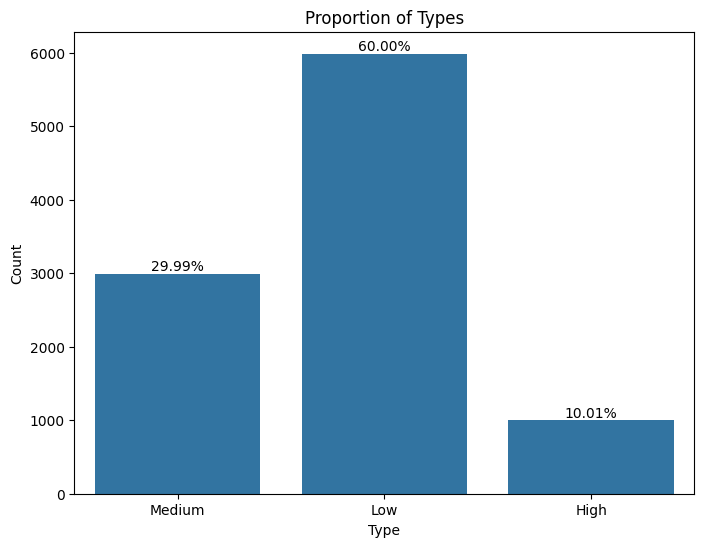

In [56]:
tipo_contagem = df['Type'].value_counts()

# Show graphic
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='Type')
plt.title('Proportion of Types')
plt.xlabel('Type')
plt.ylabel('Count')

# Add as percentages as labels
total = len(df['Type'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

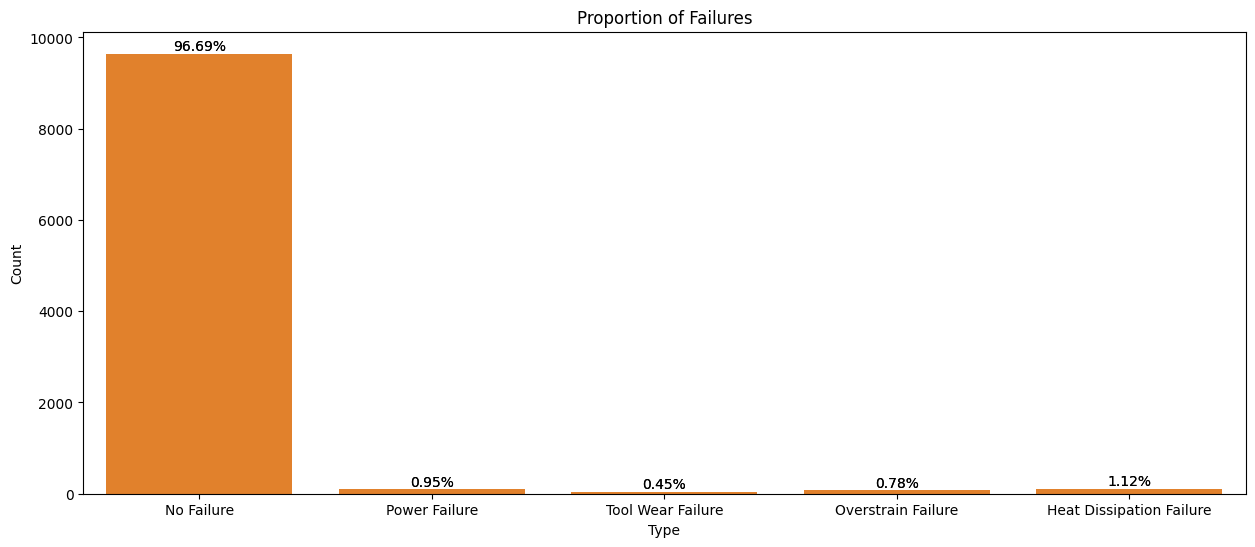

In [57]:
 #Count types
tipo_contagem = df['Failure_type'].value_counts()

# Plot bar graphic
plt.figure(figsize=(15, 6))
ax = sns.countplot(data=df, x='Failure_type')
plt.title('Proportion of Failures')
plt.xlabel('Type')
plt.ylabel('Count')

ax = sns.countplot(data=df, x = 'Failure_type')

# Add as percentages as labels
total = len(df['Failure_type'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

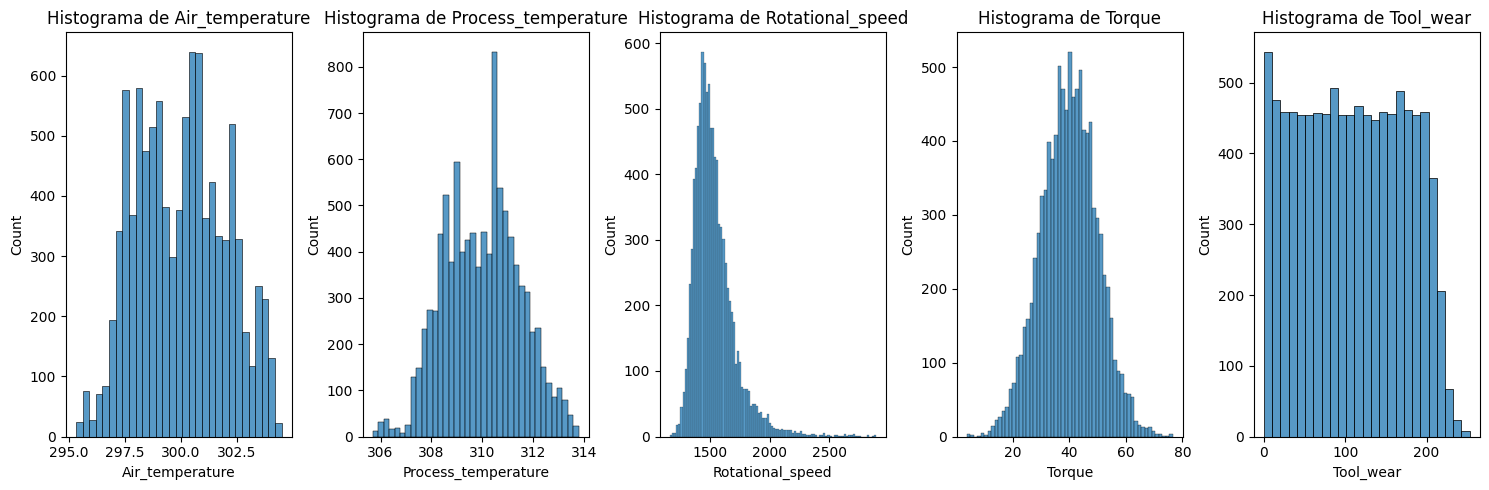

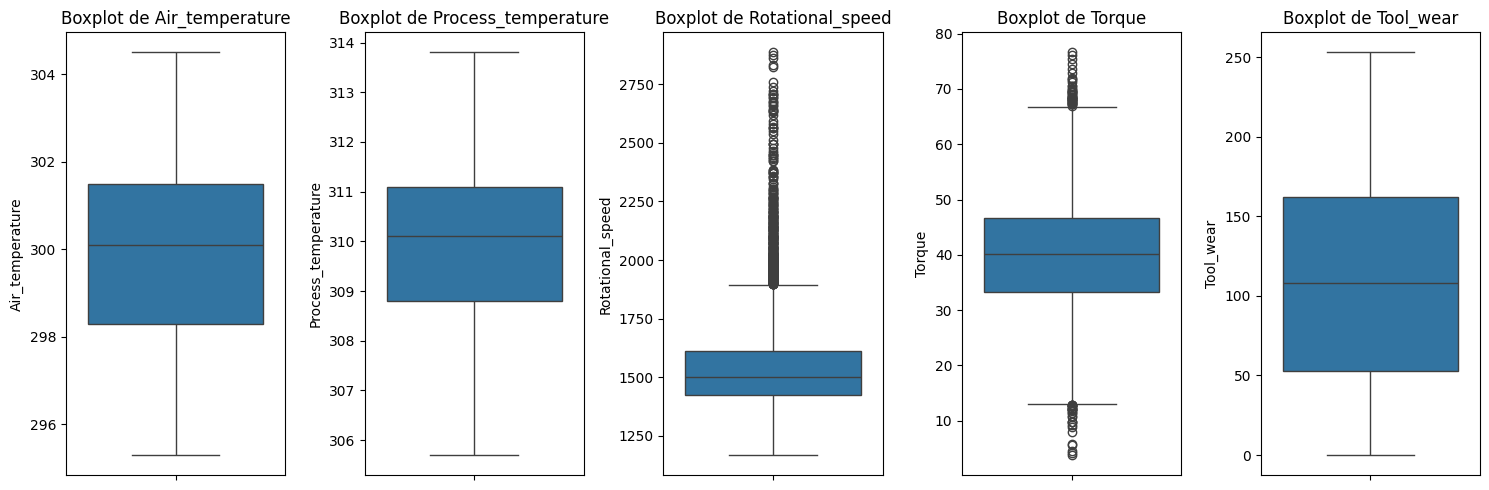

In [58]:
NUMERIC_FEATURES = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']
CATEGORIC_FEATURES = ['Type']

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

# Plot histograms
for i, feature in enumerate(NUMERIC_FEATURES):
    sns.histplot(data=df, x=feature, ax=axes[i])
    axes[i].set_title(f'Histograma de {feature}')

# Adjust subplot
plt.tight_layout()

# Show histogram
plt.show()

# Create the figure and axess
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

# Plot boxplot side by side
for i, feature in enumerate(NUMERIC_FEATURES):
    sns.boxplot(data=df, y=feature, ax=axes[i])
    axes[i].set_title(f'Boxplot de {feature}')

# Adjust subplot
plt.tight_layout()

# Show boxplots
plt.show()

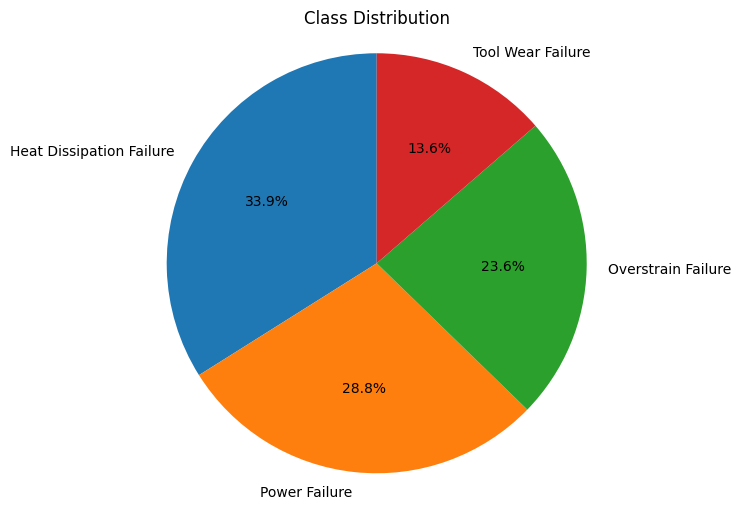

ValueError: could not convert string to float: 'Medium'

In [61]:
df_failure_type = df.loc[df['Failure_type'] != "No Failure"]
# Verifique o balanceamento resultante
proportions = df_failure_type['Failure_type'].value_counts(normalize=True)


# Plotar o gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(proportions, labels=proportions.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Assegura que o gráfico seja desenhado como um círculo
plt.title('Class Distribution')
plt.show()


In [62]:
num_pipeline = Pipeline([
    ('num_features', StandardScaler())
])

cat_pipeline = Pipeline([
    ('cat_features', OneHotEncoder())
])

# Create the ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num_trans', num_pipeline, NUMERIC_FEATURES),
    ('cat_trans', cat_pipeline, CATEGORIC_FEATURES)
])

# Fit and transform the data
df_transformed = preprocessor.fit_transform(df)

# Converting the transformed data back to a dataframe for easier visualization
# The transformed data will have new column names, especially for the one hot encoded categories
encoded_feature_names = preprocessor.named_transformers_['cat_trans'].get_feature_names_out(CATEGORIC_FEATURES)
new_column_names = list(NUMERIC_FEATURES) + list(encoded_feature_names)

df_transformed = pd.DataFrame(df_transformed, columns=new_column_names)

df_transformed.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type_High,Type_Low,Type_Medium
0,-0.951417,-0.946356,0.067484,0.283054,-1.695647,0.0,0.0,1.0
1,-0.901428,-0.878954,-0.729604,0.634238,-1.648511,0.0,1.0,0.0
2,-0.951417,-1.013759,-0.227940,0.945286,-1.617087,0.0,1.0,0.0
3,-0.901428,-0.946356,-0.590253,-0.048061,-1.585664,0.0,1.0,0.0
4,-0.901428,-0.878954,-0.729604,0.002108,-1.554240,0.0,1.0,0.0


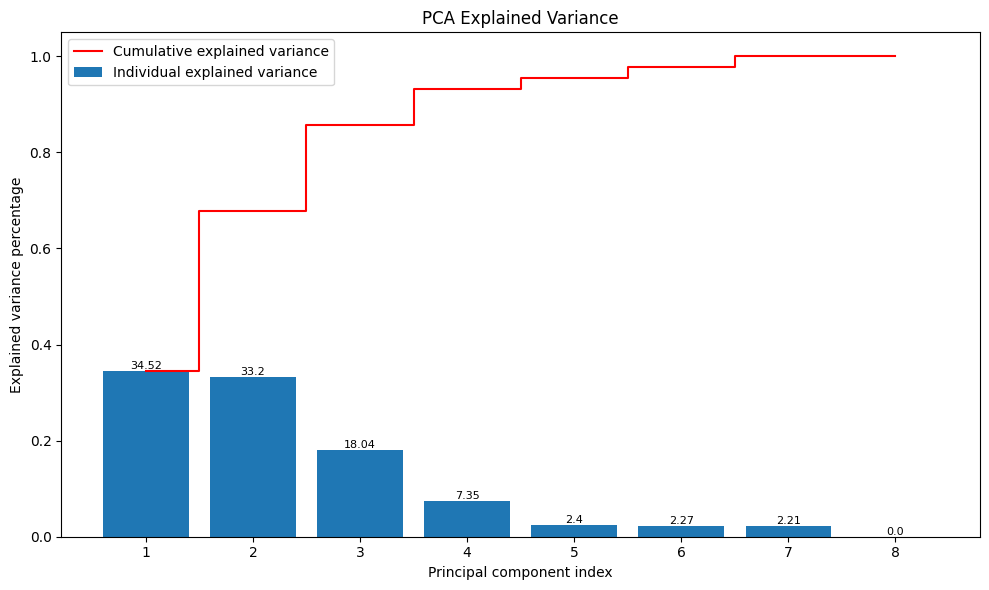

In [63]:
# Define PCA function
pca = PCA()
pca.fit(df_transformed)  # Assumindo que df_transformed é o seu DataFrame transformado

# PCA variance explained
exp_var = pca.explained_variance_ratio_
cum_exp_var = exp_var.cumsum()

# Number of components
n_pca_components = len(exp_var)

# Create the graphic
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, n_pca_components + 1), exp_var, align='center',
               label='Individual explained variance')
plt.step(range(1, n_pca_components + 1), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

# Add labels in each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval*100, 2),
             va='bottom', ha='center', fontsize=8)

# Adjust others elements of the graphic
plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, n_pca_components + 1)))
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

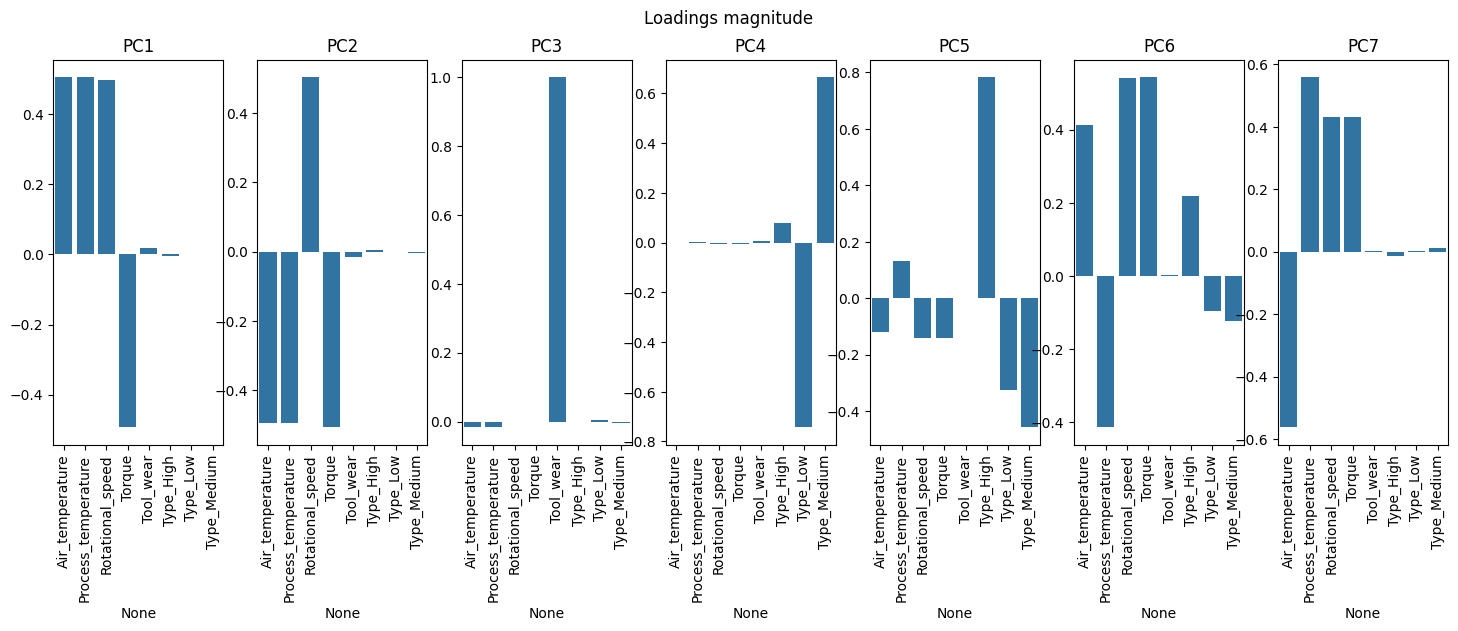

In [64]:
pca7 = PCA(n_components=7)
X_pca7 = pd.DataFrame(data=pca7.fit_transform(df_transformed), columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7'])

# Configure of the graphics
fig, axs = plt.subplots(ncols=7, figsize=(18,5))
fig.suptitle('Loadings magnitude')


all_features = NUMERIC_FEATURES + list(encoded_feature_names)  # Use encoded_feature_names do
pca_loadings = pd.DataFrame(data=pca7.components_, columns=all_features)

#Plot the bar graphics
for j in range(7):
    ax = axs[j]
    sns.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))

plt.show()

In [65]:
from sklearn.metrics import f1_score

def get_metrics(y_true, y_pred):
    # Calculating F1 scores for each class
    f1_scores_per_class = f1_score(y_true, y_pred, average=None)

    dict_metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Macro Recall': recall_score(y_true, y_pred, average='macro'),
        'Macro Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro F1': f1_score(y_true, y_pred, average='macro'),
        'F1 Scores per Class': f1_scores_per_class
    }
    return dict_metrics

In [68]:
df_model = df.copy()
X = df_model[NUMERIC_FEATURES + CATEGORIC_FEATURES]
y = df_model['Failure_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
pip_model_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=4)),
    ('model', RandomForestClassifier(random_state=2023))
])

# Fit pipeline with PCA
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_pca.fit(X_train, y_train, model__sample_weight=weights)

# Generate Predictions using the correctly fitted pipeline
y_pred = pip_model_pca.predict(X_test)

# Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# View Results
metrics

{'Accuracy': 0.9699248120300752,
 'Balanced Accuracy': 0.28344895091539113,
 'Macro Recall': 0.28344895091539113,
 'Macro Precision': 0.5940613990941117,
 'Macro F1': 0.33026898195437526,
 'F1 Scores per Class': array([0.        , 0.98467824, 0.47619048, 0.19047619, 0.        ])}

In [69]:
pip_model_no_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(random_state=2023))
])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_no_pca.fit(X_train, y_train, model__sample_weight=weights)

# Step 1: Generate Predictions
y_pred = pip_model_no_pca.predict(X_test)

# Step 2: Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# Step 3: View Results
metrics

{'Accuracy': 0.9543859649122807,
 'Balanced Accuracy': 0.8088413913217465,
 'Macro Recall': 0.8088413913217465,
 'Macro Precision': 0.5805520745597669,
 'Macro F1': 0.6480662154359346,
 'F1 Scores per Class': array([0.78571429, 0.9762533 , 0.53658537, 0.7804878 , 0.16129032])}

In [70]:
# Get categorical feature indices for SMOTENC
categorical_features_indices = [i for i, feature in enumerate(NUMERIC_FEATURES + CATEGORIC_FEATURES)
                                if feature in CATEGORIC_FEATURES]

# Creating the new pipeline with SMOTENC using ImbPipeline
pip_model_smotenc = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smotenc', SMOTENC(categorical_features=categorical_features_indices, random_state=42)),
    ('model', GradientBoostingClassifier(random_state=2023))
])

# Fit the pipeline
pip_model_smotenc.fit(X_train, y_train)

# Generate Predictions
y_pred = pip_model_smotenc.predict(X_test)

# Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# View Results
metrics

{'Accuracy': 0.9453634085213033,
 'Balanced Accuracy': 0.8441640973870653,
 'Macro Recall': 0.8441640973870653,
 'Macro Precision': 0.5652665808354431,
 'Macro F1': 0.6459840893394302,
 'F1 Scores per Class': array([0.8       , 0.97132236, 0.63636364, 0.69565217, 0.12658228])}

In [71]:
pip_model_no_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(random_state=2023))
])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_no_pca.fit(X_train, y_train, model__sample_weight=weights)

# Updated parameters for GridSearchCV
params = {
    'model': [
        LogisticRegressionCV(max_iter=500, random_state=2023),
        RandomForestClassifier(random_state=2023),
        GradientBoostingClassifier(random_state=2023),
        DummyClassifier()
    ],
}

# Running GridSearchCV
grid = GridSearchCV(pip_model_no_pca, params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Collecting and printing the results
results = pd.DataFrame(grid.cv_results_)
best_model_index = results['mean_test_score'].idxmax()
best_model_params = results.loc[best_model_index, 'params']

# View results
print("Best model:")
print(best_model_params)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best model:
{'model': GradientBoostingClassifier(random_state=2023)}


In [ ]:
# New parameters for fine-tuning the RandomForestClassifier
fine_tune_params = {

    'model__n_estimators': [50, 100, 200, 300, 400, 500],
    'model__max_depth': [None, 5, 10, 15, 20]
}

# Running a new GridSearchCV for fine-tuning
fine_tune_grid = GridSearchCV(pip_model_no_pca, fine_tune_params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
fine_tune_grid.fit(X_train, y_train)

# Collecting and printing the fine-tuned results
fine_tuned_results = pd.DataFrame(fine_tune_grid.cv_results_)
fine_tuned_best_index = fine_tuned_results['mean_test_score'].idxmax()
fine_tuned_best_params = fine_tuned_results.loc[fine_tuned_best_index, 'params']

# Print best model parameters
print("Best fine-tuned model parameters:")
print(fine_tuned_best_params)

# Finding the best estimator paramaters
tuned_model = fine_tune_grid.best_estimator_
y_pred = tuned_model.predict(X_test)

# View new perfomance (focus on F1-score)
get_metrics(y_test, y_pred)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


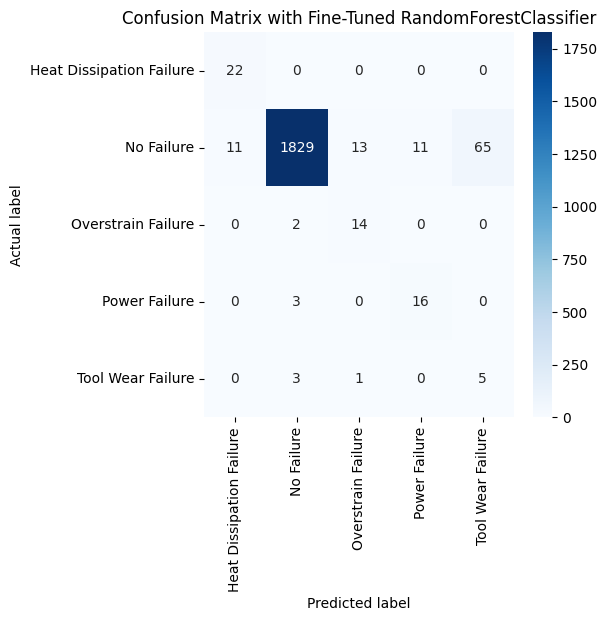

In [73]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))  # Larger figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  # Use 'd' to format numbers as integers
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_pred))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix with Fine-Tuned RandomForestClassifier')
plt.show()